<a href="https://colab.research.google.com/github/SourLemon23/blueprint-2021/blob/main/Face_Pose_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

import _pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping

!pip install fer
from fer import FER
import base64

Authorize Access to Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data

In [ ]:
training_dataset = r'/content/drive/MyDrive/Colab Notebooks/MIT Blueprint 2021/Face Pose Estimator/samples.pkl'
x, y = pkl.load(open(training_dataset, 'rb'))

Split Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                y_test,
                                                test_size=0.5, 
                                                random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


Data Normalization

In [ ]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

Create Model

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 500

In [ ]:
model = Sequential()

model.add(Dense(units=20,
                activation='relu',
                kernel_regularizer='l2',
                input_dim=x.shape[1]))

model.add(Dense(units=10,
                activation='relu',
                kernel_regularizer='l2'))

model.add(Dense(units=3,
                activation='linear'))

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 20)                45580     
_________________________________________________________________
dense_28 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 33        
Total params: 45,823
Trainable params: 45,823
Non-trainable params: 0
_________________________________________________________________
None


Train the Model

In [ ]:
callback_list = [EarlyStopping(monitor='val_loss', patience=20)]

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics='accuracy')

hist = model.fit(x=x_train,
                 y=y_train,
                 validation_data=(x_val, y_val),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=callback_list)

Epoch 1/500
138/138 [==============================] - 1s 5ms/step - loss: 81.5256 - accuracy: 0.5146 - val_loss: 59.2448 - val_accuracy: 0.6023
Epoch 2/500
138/138 [==============================] - 0s 3ms/step - loss: 48.2905 - accuracy: 0.6102 - val_loss: 41.2190 - val_accuracy: 0.6257
Epoch 3/500
138/138 [==============================] - 0s 3ms/step - loss: 37.2130 - accuracy: 0.6555 - val_loss: 38.5963 - val_accuracy: 0.7190
Epoch 4/500
138/138 [==============================] - 0s 3ms/step - loss: 35.1407 - accuracy: 0.6914 - val_loss: 38.0544 - val_accuracy: 0.7084
Epoch 5/500
138/138 [==============================] - 0s 3ms/step - loss: 34.0332 - accuracy: 0.6970 - val_loss: 38.6498 - val_accuracy: 0.6660
Epoch 6/500
138/138 [==============================] - 0s 3ms/step - loss: 33.5440 - accuracy: 0.7118 - val_loss: 39.3760 - val_accuracy: 0.6755
Epoch 7/500
138/138 [==============================] - 0s 3ms/step - loss: 36.3217 - accuracy: 0.7041 - val_loss: 36.4804 - val_ac

In [ ]:
model_filepath = r'/content/drive/MyDrive/Colab Notebooks/MIT Blueprint 2021/Face Pose Estimator/models'
# model.save(model_filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MIT Blueprint 2021/Face Pose Estimator/models/assets


Evaluate Model

Best Training Accuracy: 75.07%
Best Validation Accuracy: 75.60%
Best Training Loss: 29.73
Best Validation Loss: 32.10


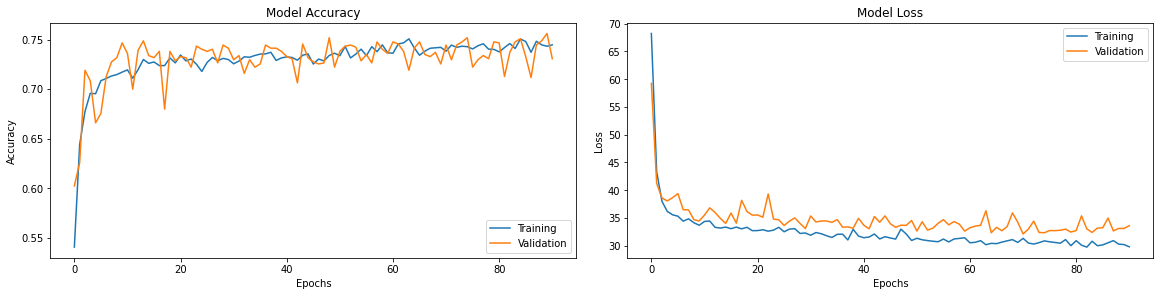

In [ ]:
history = hist.history

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), constrained_layout=True)
for i, metric in enumerate(['accuracy', 'loss']):
    if 'loss' in metric:
        print('Best Training ' + metric.capitalize() + ':', str(min(history[metric]))[:5])
        print('Best Validation ' + metric.capitalize() + ':', str(min(history['val_' + metric]))[:5])
    else:
        print('Best Training ' + metric.capitalize() + ':', str(max(history[metric]) * 100)[:5] + '%')
        print('Best Validation ' + metric.capitalize() + ':', str(max(history['val_' + metric]) * 100)[:5] + '%')
    
    axs[i].plot(history[metric])
    axs[i].plot(history['val_' + metric])
    axs[i].set_title('Model {}'.format(metric.capitalize()))
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(metric.capitalize())
    axs[i].legend(['Training', 'Validation'])

In [ ]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    shape_predictor_path = r'/content/drive/MyDrive/Colab Notebooks/MIT Blueprint 2021/Face Pose Estimator/models/shape_predictor_68_face_landmarks.dat'
    predictor = dlib.shape_predictor(shape_predictor_path)
    face_rect = detector(image, 1)
    if len(face_rect) != 1:
        return []

    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "Face Points Mismatch"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i + 1, 68):
            features.append(np.linalg.norm(face_points[i] - face_points[j]))
            
    return np.array(features).reshape(1, -1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


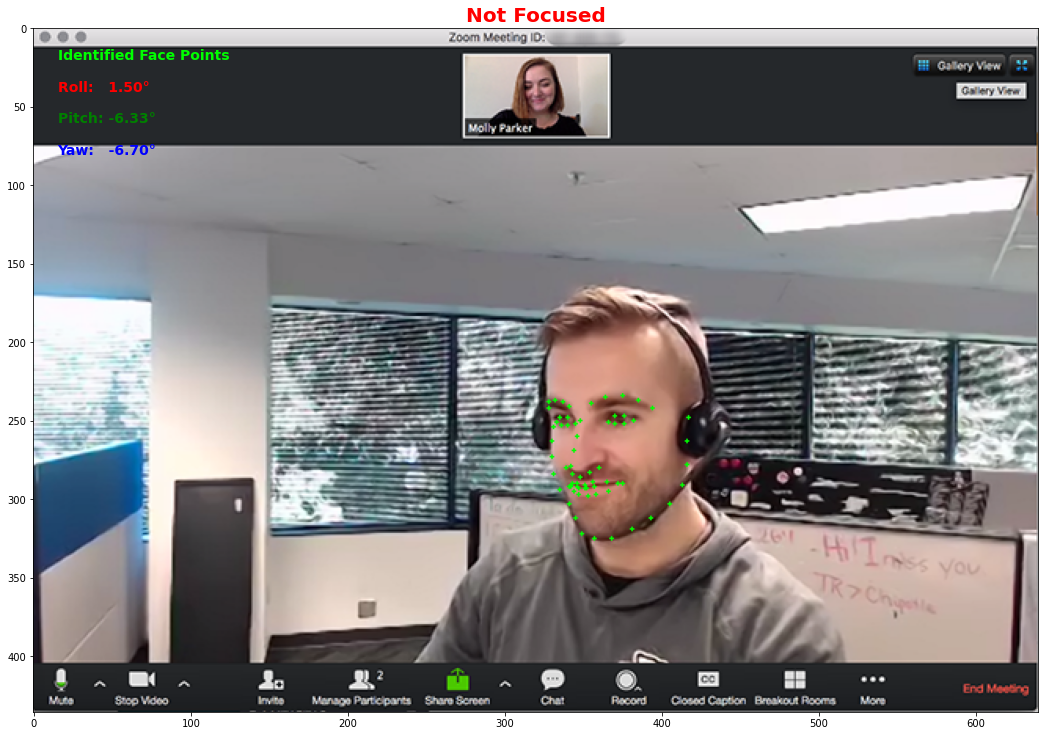

In [ ]:
model = load_model(model_filepath)
testing_img_path = r'/content/drive/MyDrive/Colab Notebooks/MIT Blueprint 2021/Face Pose Estimator/Testing Images/zoom guy.png'

img = cv2.imread(testing_img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(img)

for x, y in face_points:
    cv2.circle(img, (x, y), 1, (0, 255, 0), -1)
    
try:
    features = compute_features(face_points)
    features = std.transform(features)
    located_face_points = True
except:
    located_face_points = False

y_pred = model.predict(features)
roll, pitch, yaw = y_pred[0]

MAX_ROTATION = 90

# Calculate an overall percentage describing the student's focus/attention level
focus_score = (((MAX_ROTATION - abs(roll)) + (MAX_ROTATION - abs(pitch)) + (MAX_ROTATION - abs(yaw)))/(3 * MAX_ROTATION)) * 100
FOCUSED_THRESHOLD = 10

if FOCUSED_THRESHOLD < focus_score:
    status = 'Not Focused'
else:
    status = 'Focused'
    
plt.figure(figsize=(18, 18))
font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  20}

plt.title(status, fontdict=font_settings)

if located_face_points:
    font_settings.update({'color' : 'lime', 'size': 14})
    plt.text(15, 20, 'Identified Face Points', fontdict=font_settings)
else:
    font_settings.update({'color' : 'firebrick', 'size': 14})
    plt.text(15, 20, 'Unidentifiable Face Points', fontdict=font_settings)

font_settings.update({'color': 'red'})
plt.text(15, 40, 'Roll:   {:.2f}°'.format(roll), fontdict=font_settings)
font_settings.update({'color': 'green'})
plt.text(15, 60, 'Pitch: {:.2f}°'.format(pitch), fontdict=font_settings)
font_settings.update({'color': 'blue'})
plt.text(15, 80, 'Yaw:   {:.2f}°'.format(yaw), fontdict=font_settings)

plt.imshow(img)
plt.show()

Facial Expression Recognition
Implementation of the FER Libr


In [253]:
from google.colab import files
uploaded = files.upload()

Saving zoom guy.png to zoom guy.png


In [254]:
def wrapper(encoded_string):
  imgdata = base64.b64decode(encoded_string)
  filename = "output.jpg"
  with open(filename, "wb") as f:
    f.write(imgdata)
    f.close()  

In [255]:
# Returns the emotion and score of the input filename
# against the encoded_string as a tuple.
#
# Input:
#   encoded_string: Base64 encoded string of the image contents.
#   filename: The uploaded image file.  
# Return:
#  A tuple of emotion and score.
def face_recognition(filename):
    img = plt.imread(filename)
    predictor = FER(mtcnn=True)
    print(predictor.detect_emotions(img))
    
    emotion, score = predictor.top_emotion(img)

    # ---------------------------------------------------------

    face_points = detect_face_points(img)

    for x, y in face_points:
        cv2.circle(img, (x, y), 1, (0, 255, 0), -1)
        
    try:
        features = compute_features(face_points)
        features = std.transform(features)
        located_face_points = True
    except:
        located_face_points = False

    y_pred = model.predict(features)
    roll, pitch, yaw = y_pred[0]

    MAX_ROTATION = 90

    # Calculate an overall percentage describing the student's focus/attention level
    focus_score = (((MAX_ROTATION - abs(roll)) + (MAX_ROTATION - abs(pitch)) + (MAX_ROTATION - abs(yaw)))/(3 * MAX_ROTATION)) * 100
    FOCUSED_THRESHOLD = 10

    if FOCUSED_THRESHOLD < focus_score:
        status = 'Not Focused'
    else:
        status = 'Focused'
        
    plt.figure(figsize=(18, 18))
    font_settings = {'family': 'DejaVu Sans',
                      'color' : 'red',
                      'weight': 'heavy',
                      'size'  :  20}

    plt.title(status, fontdict=font_settings)

    if located_face_points:
        font_settings.update({'color' : 'lime', 'size': 14})
        plt.text(15, 20, 'Identified Face Points', fontdict=font_settings)
    else:
        font_settings.update({'color' : 'firebrick', 'size': 14})
        plt.text(15, 20, 'Unidentifiable Face Points', fontdict=font_settings)

    font_settings.update({'color': 'red'})
    plt.text(15, 40, 'Roll:   {:.2f}°'.format(roll), fontdict=font_settings)
    font_settings.update({'color': 'green'})
    plt.text(15, 60, 'Pitch: {:.2f}°'.format(pitch), fontdict=font_settings)
    font_settings.update({'color': 'blue'})
    plt.text(15, 80, 'Yaw:   {:.2f}°'.format(yaw), fontdict=font_settings)

    plt.imshow(img)
    plt.show()

    return focus_score

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[{'box': (386, 125, 301, 301), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]


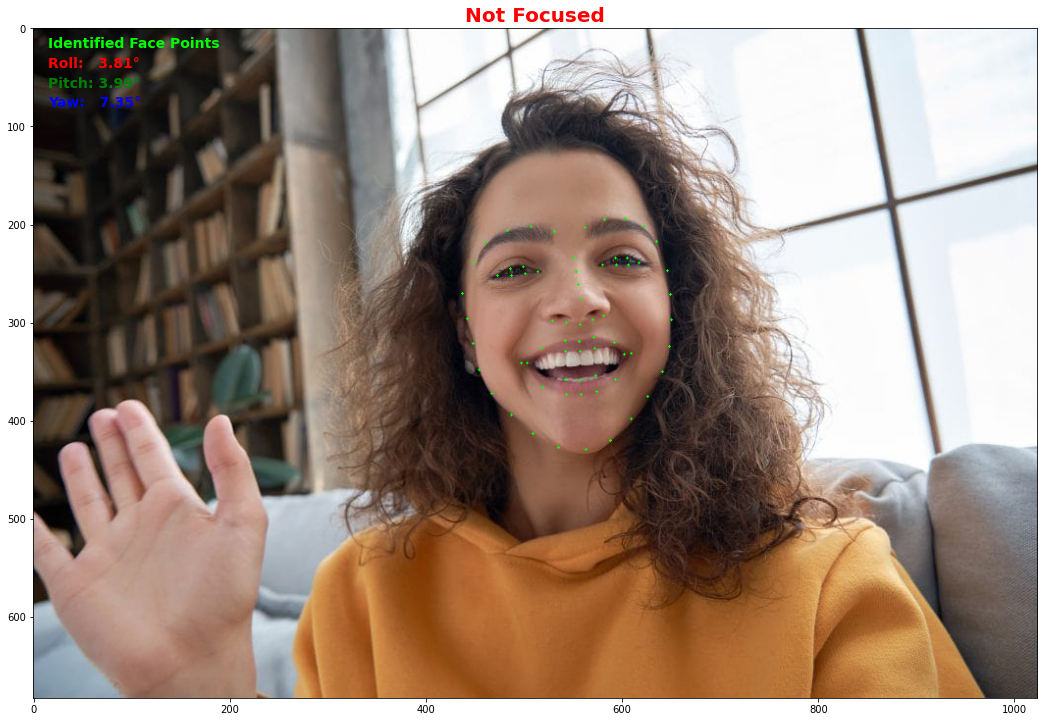

In [256]:
# TEST THE PREDICTION!!!
with open("zoom1.jpg", "rb") as img_file:
    wrapper(base64.b64encode(img_file.read()))
    focus_score = face_recognition('output.jpg')
    

# img_file.close()